In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
import plotly.offline as py
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
import base64
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from wordcloud import WordCloud, STOPWORDS
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import os
import itertools
import seaborn as sns
color = sns.color_palette()
import xgboost as xgb
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
import string
punctuations = string.punctuation
import warnings  
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load raw data from csv

In [50]:
csv = "/Users/galmoore/anaconda/envs/NLP_notebooks/simpsons_nlp/the-simpsons-by-the-data/simpsons_script_lines.csv"
df = pd.read_csv(csv,error_bad_lines=False,warn_bad_lines=False,low_memory=False)
df.shape
df.head(3)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0


### Who is speaking the most? 

In [51]:
most_speaking_df = df.groupby("raw_character_text")\
                   .count().sort_values(["normalized_text"],\
                   ascending=False)\
                   .head(10)
most_speaking_df

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_location_text,spoken_words,normalized_text,word_count
raw_character_text,,,,,,,,,,,,
Homer Simpson,29839,29839,29839,29839,29839,29839,29839,29769,29769,27909,27906,27909
Marge Simpson,14157,14157,14157,14157,14157,14157,14157,14133,14133,13191,13189,13191
Bart Simpson,13776,13776,13776,13776,13776,13776,13776,13762,13762,13012,13010,13012
Lisa Simpson,11500,11500,11500,11500,11500,11500,11500,11483,11483,10767,10765,10767
C. Montgomery Burns,3172,3172,3172,3172,3172,3172,3172,3172,3172,3087,3086,3087
Moe Szyslak,2863,2863,2863,2863,2863,2863,2863,2861,2861,2809,2809,2809
Seymour Skinner,2443,2443,2443,2443,2443,2443,2443,2438,2438,2390,2390,2390
Ned Flanders,2145,2145,2145,2145,2145,2145,2145,2141,2141,2057,2056,2057
Grampa Simpson,1886,1886,1886,1886,1886,1886,1886,1881,1881,1807,1807,1807


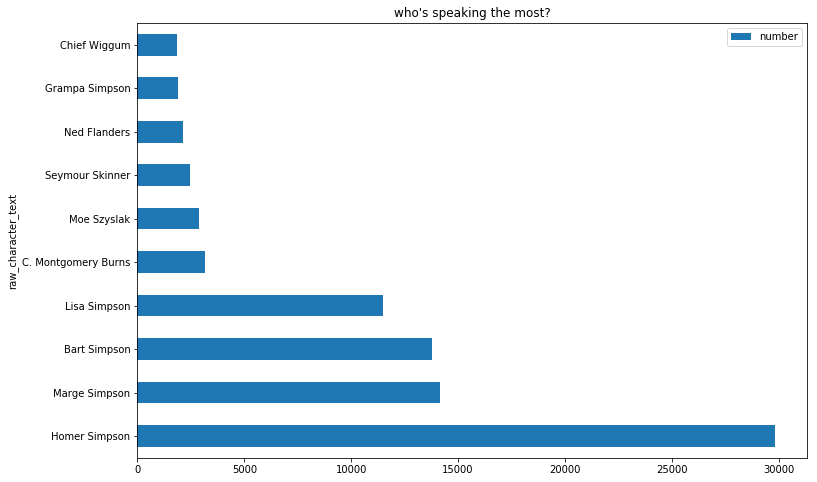

In [52]:
most_speaking_df.head(10).plot(y="number",fontsize=10,kind = "barh"\
                               ,figsize=(12,8),title="who's speaking the most?")


### Let's grab data from just Lisa and Bart and see if we can build a classifier

In [53]:
# Drop null rows
df = df.dropna(how='any',axis=0)
# filter out rows not spoken by Lisa or Bart
df = df[df["raw_character_text"].isin(["Bart Simpson","Lisa Simpson"])]
# remove all columns we don't need
df = df[["id","spoken_words","raw_character_text"]]
# change column names
df.columns = ["id","text","author"]
# rebase index 
df.index = pd.RangeIndex(len(df.index))
# rename to train
train = df
train.head()


,id,text,author
0,9550,Where's Mr. Bergstrom?,Lisa Simpson
1,9552,That life is worth living.,Lisa Simpson
2,9556,Victory party under the slide!,Bart Simpson
3,9558,Mr. Bergstrom! Mr. Bergstrom!,Lisa Simpson
4,9560,Do you know where I could find him?,Lisa Simpson


In [64]:
z = {'Lisa Simpson': 'Lisa Simpson', 'Bart Simpson': 'Bart Simpson', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),text='Text entries attributed to Author'
    )]
layout = go.Layout(title='Text entries attributed to each speaker', autosize=False,
    width=500,
    height=300,)
fig = go.Figure(data=data, layout=layout)
# fig(figsize=(8,4))

py.iplot(fig, filename='basic-bar')

### Visualise our two classes - are they very different?

In [8]:
bart = train[train.author=="Bart Simpson"]["text"].values
lisa = train[train.author=="Lisa Simpson"]["text"].values


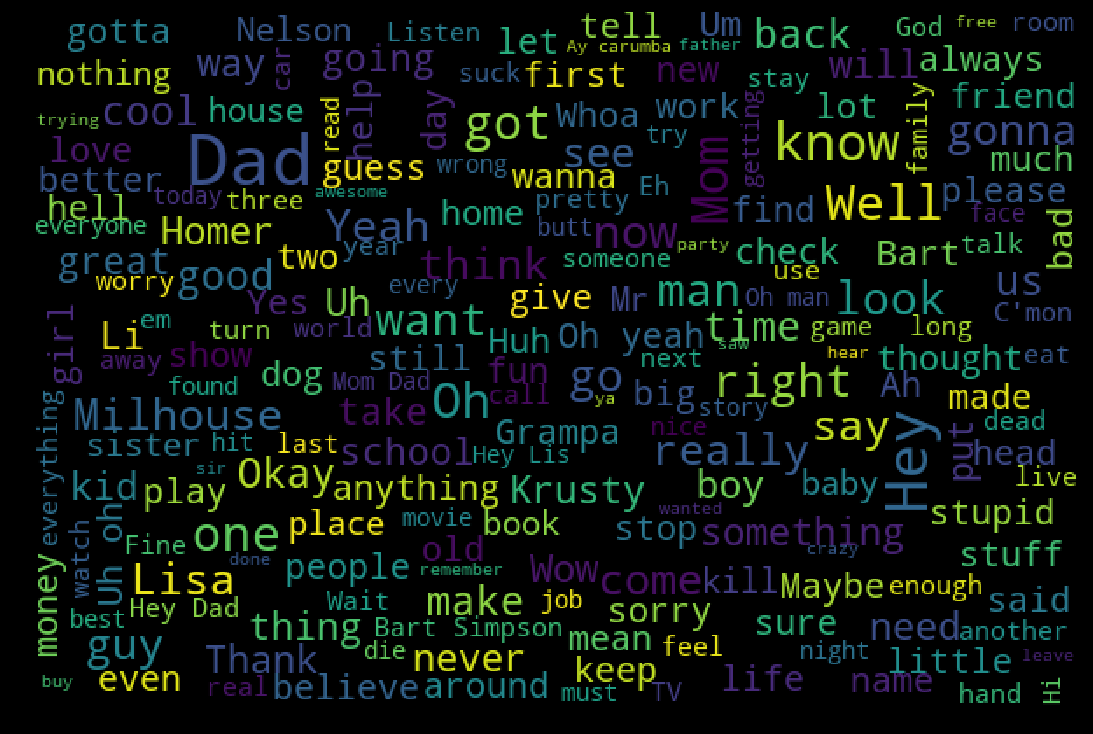

In [9]:
bart_wordcloud = WordCloud(background_color="black", stopwords=STOPWORDS, max_font_size= 40,
                           width=600, height=400).generate(" ".join(bart))
plt.figure( figsize=(15,10), facecolor='k')
plt.imshow(bart_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

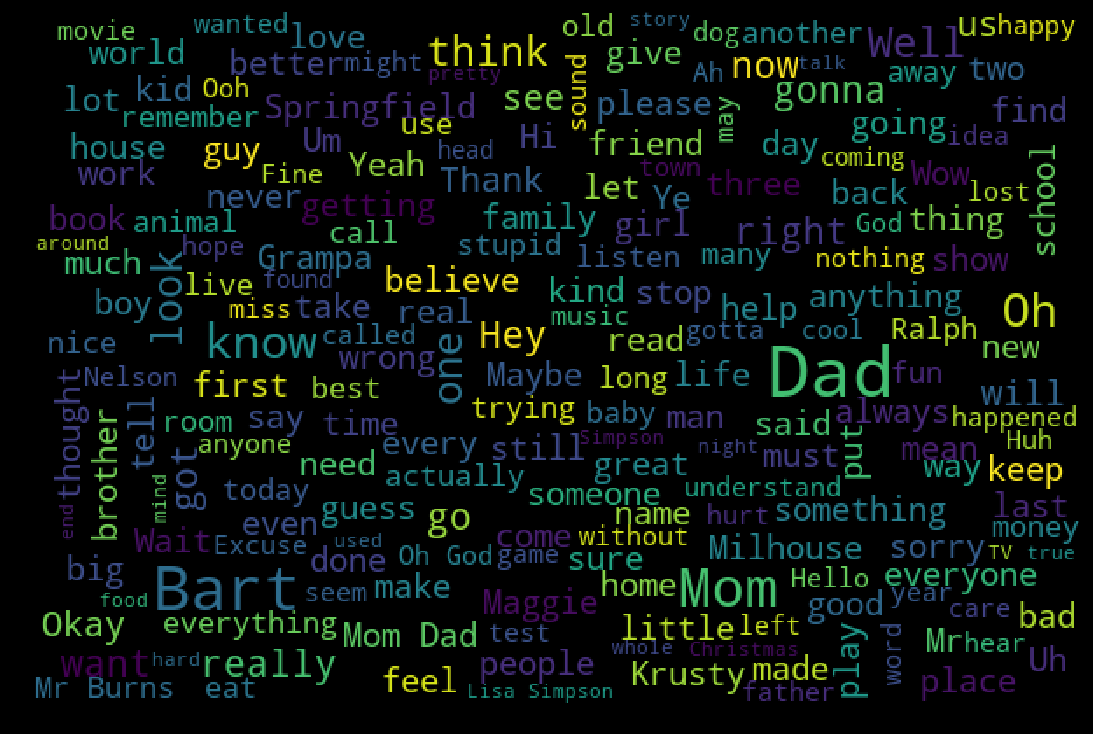

In [11]:
lisa_wordcloud = WordCloud(background_color="black", stopwords=STOPWORDS, max_font_size= 40,
                           width=600, height=400).generate(" ".join(lisa))
plt.figure( figsize=(15,10), facecolor='k')
plt.imshow(lisa_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [12]:
# create label encoder object
lbl_enc = preprocessing.LabelEncoder()
# get ground truth labels in numbers rather than names ()
y = lbl_enc.fit_transform(train.author.values)

In [13]:
# Split data and labels in a stratified way (same ratio)
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

print(xtrain.shape, "xtrain is a one dimensional ndarray with 21,370 strings of text that were spoken")
print(ytrain.shape, "ytrain is a one dimensional ndarray with 21,370 labels for the corresponding texts")
print(xvalid.shape, "xvalid is a one dimensional ndarray with 2,375 strings of text that were spoken")
print(yvalid.shape, "yvalid is a one dimensional ndarray with 2,375 labels for the corresponding texts")

(21370,) xtrain is a one dimensional ndarray with 21,370 strings of text that were spoken
(21370,) ytrain is a one dimensional ndarray with 21,370 labels for the corresponding texts
(2375,) xvalid is a one dimensional ndarray with 2,375 strings of text that were spoken
(2375,) yvalid is a one dimensional ndarray with 2,375 labels for the corresponding texts


In [14]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota


In [15]:
# Our very first model is a simple TF-IDF 
# (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.
# Always start with these features. They work (almost) everytime!
# tfv == terf frequency vector
# min_df should be higher (4 or 10)
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [16]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
# clf.score(yvalid,predictions)
# print(type(xvalid))
# print(type(predictions))
# print(yvalid)
# print(predictions)

logloss: 0.614 


### Do another countvectorizer prediction with Spacy tokenizer


In [17]:
# Get the train df again
train = df
# change format so fits easily with existing code
train["speaker_id"] = y
# Bart Simpson is 0
# Lisa Simpson is 1
# remove irrelevant columns
train = train[["text","speaker_id"]]
train.columns = "Message","Target"
print(train.shape)
train.head(10)

(23745, 2)


,Message,Target
0,Where's Mr. Bergstrom?,1
1,That life is worth living.,1
2,Victory party under the slide!,0
3,Mr. Bergstrom! Mr. Bergstrom!,1
4,Do you know where I could find him?,1
5,"The train, how like him... traditional, yet en...",1
6,"I see he touched you, too.",1
7,"Hey, thanks for your vote, man.",0
8,"Well, you got that right. Thanks for your vote...",0
9,"Well, don't sweat it. Just so long as a couple...",0


In [18]:
# Build a list of stopwords from Spacy to use to filter
stopwords = list(STOP_WORDS)
print(len(stopwords)) # off the shelf stop words
print(stopwords[:5])
# remove stopwords 
train['Message'] = train['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
train.head(10)

305
['hundred', 'never', 'twenty', 'one', 'above']


,Message,Target
0,Where's Mr. Bergstrom?,1
1,That life worth living.,1
2,Victory party slide!,0
3,Mr. Bergstrom! Mr. Bergstrom!,1
4,Do know I find him?,1
5,"The train, like him... traditional, environmen...",1
6,"I touched you, too.",1
7,"Hey, thanks vote, man.",0
8,"Well, got right. Thanks vote, girls.",0
9,"Well, don't sweat it. Just long couple people ...",0


In [19]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [20]:
# Creating a Spacy Parser
from spacy.lang.en import English
parser = English()

In [21]:
# Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()

In [22]:
# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
classifier = LinearSVC()

In [23]:
# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [24]:
# Splitting Data Set
from sklearn.model_selection import train_test_split

In [25]:
# Features and Labels
X = train['Message']
ylabels = train['Target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [27]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [28]:
# Fit our data
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x1a209ead30>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngra...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [29]:
# Predicting with a test dataset
sample_prediction = pipe.predict(X_test)

In [31]:
# Prediction Results
# 1 = Lisa Simpson
# 0 = Bart Simpson
# for (sample,pred) in zip(X_test,sample_prediction):
#     print(sample,"Prediction=>",pred)

In [32]:
# Accuracy on unseen data
print("Accuracy: ",pipe.score(X_test,y_test))
print("Accuracy: ",pipe.score(X_test,sample_prediction))

Accuracy:  0.6329753632343651
Accuracy:  1.0


In [33]:
# Accuracy on learned data
print("Accuracy: ",pipe.score(X_train,y_train))

Accuracy:  0.8214887344704148


In [37]:
# more predictions
# 1 = Lisa Simpson
# 0 = Bart Simpson
example = ["lisa",
           "oh boy",
           "mum",
           "dad",
           "bart",
           "I'm sad",
           "ay caramba"]
pipe.predict(example)


array([0, 0, 0, 1, 1, 1, 0])

### When we put our trained classifer to the test it does a good job! Our low prediction score (63%) is probably due to the variability in lengths of the speaking parts. Many speaking parts are only a couple words long, and it is just not practically feasible to predict which character they belong too - especially as we know we are looking at tens of thousands of words. But "easy" cases like "ay caramba" or "Bart" are easily classified.

### Using Tfid


In [38]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe_tfid = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfvectorizer),
                 ('classifier', classifier)])

In [39]:
pipe_tfid.fit(X_train,y_train)


Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x1a23bda780>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngra...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [40]:
sample_prediction1 = pipe_tfid.predict(X_test)


In [41]:
# for (sample,pred) in zip(X_test,sample_prediction1):
#     print(sample,"Prediction=>", pred)

In [43]:
print("Accuracy: ",pipe_tfid.score(X_test,y_test))
print("Accuracy: ",pipe_tfid.score(X_test,sample_prediction1))

Accuracy:  0.6363444935775953
Accuracy:  1.0


### Using a TFIDF we get accuracy 0.3% higher. Our vocabulary is probably to big. 

### XGBOOST AND FEATURE ENGINEERING

In [44]:
## I saved the dataset of ~ 24k rows of only Bart and Lisa to two csv files. 
# Load the csv files! 
# latin encoding important because we need csv to be read as UTF-8
train_df = pd.read_csv("csv_simpsons_xgboost/train_simpsons.csv",encoding='latin-1') 
test_df = pd.read_csv("csv_simpsons_xgboost/test_simpsons.csv",encoding='latin-1')
# train_df = pd.read_csv("spooky-author-identification/train.csv")
# test_df = pd.read_csv("spooky-author-identification/test.csv")
print("We are expecting train to have 3 columns and test to have 2")
print("rows in train dataset : ",train_df.shape[0],"columns in dataset :",train_df.shape[1])
print("Number of rows in test dataset : ",test_df.shape[0],"columns in test set :",test_df.shape[1])

We are expecting train to have 3 columns and test to have 2
rows in train dataset :  18996 columns in dataset : 3
Number of rows in test dataset :  4749 columns in test set : 2


In [45]:
for i in range(20):
    print(train_df.iloc[i][1],"(" ,train_df.iloc[i][2],")")

Hey, women have put out just to get out of there. ( Bart Simpson )
Not if I spend the whole time running around like this. ( Bart Simpson )
Wow! The TV's coin-operated. ( Bart Simpson )
Kiss you? But, Dad, I'm your kid! ( Bart Simpson )
I guess my little yearbook stunt was pretty rough, but it did teach you a lesson: It's important to be yourself. ( Bart Simpson )
Will this Christmas never end? ( Bart Simpson )
But I worked so hard! I've got dirt under my fingernails I'll never get out. Not that I'm gonna try. ( Bart Simpson )
Excuse me, but isn't that voice very similar to the Cowardly Lion? ( Lisa Simpson )
INT. LAKESIDE MANSION - KITCHEN - PRESENT - LATER ( Bart Simpson )
I know this obsession with thinness is unhealthy and anti-feminist... but that's what a fat girl would say! ( Lisa Simpson )
Gramma, have you ever thought about moving back to Springfield? ( Lisa Simpson )
Arrrgh! ( Bart Simpson )
He's right, mom. ( Bart Simpson )
Like, you know, whatever. ( Lisa Simpson )
Ballet i

In [46]:
train_df.groupby('author').describe()

id                                                       \
                count          mean           std   min       25%      50%   
author                                                                       
Bart Simpson  10342.0  72981.168729  47611.210953  34.0  30549.25  69621.0   
Lisa Simpson   8654.0  79878.420730  44861.305822  62.0  42270.75  79642.0   

                                   
                    75%       max  
author                             
Bart Simpson  117318.50  158247.0  
Lisa Simpson  119608.75  158250.0

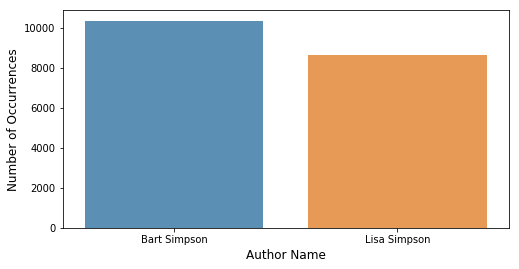

In [47]:
# visualise data split between classes
cnt_srs = train_df['author'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

### Create new features

In [65]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [66]:
train_df.groupby('author').describe()

id                                                       \
                count          mean           std   min       25%      50%   
author                                                                       
Bart Simpson  10342.0  72981.168729  47611.210953  34.0  30549.25  69621.0   
Lisa Simpson   8654.0  79878.420730  44861.305822  62.0  42270.75  79642.0   

                                  num_words            ...  num_words_title  \
                    75%       max     count      mean  ...              75%   
author                                                 ...                    
Bart Simpson  117318.50  158247.0   10342.0  8.426030  ...              2.0   
Lisa Simpson  119608.75  158250.0    8654.0  9.262306  ...              2.0   

                   mean_word_len                                               \
               max         count      mean       std  min       25%       50%   
author                                                                          
Bart Simpson  41.0       10342.0  4.575522  1.315457  1.0  3.866667  4.333333   
Lisa Simpson  20.0        8654.0  4.664293  1.487977  2.0  4.000000  4.428571   

                         
              75%   max  
author                   
Bart Simpson  5.0  52.0  
Lisa Simpson  5.0  51.0  

[2 rows x 72 columns]

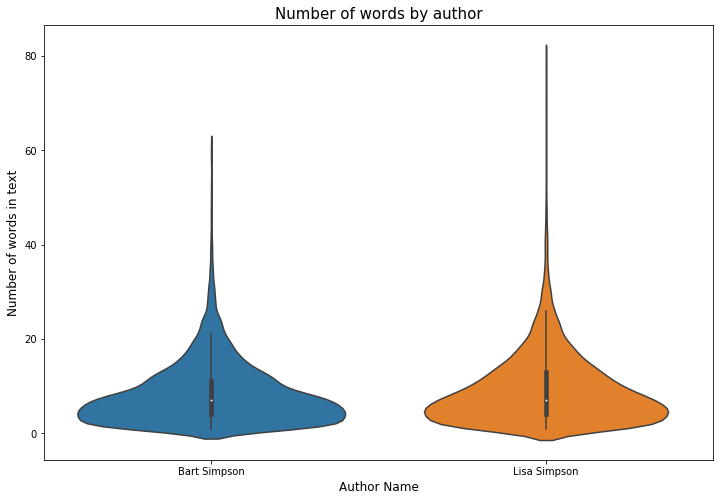

In [67]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

### Classes & Author mapping


In [69]:
classes = 2
author_mapping_dict = {'Bart Simpson':0, 'Lisa Simpson':1}

In [70]:
## Prepare the data for modeling ###
# author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [71]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = classes
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

#### Here we call the runXGB function

In [72]:
kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], classes])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:0.691484	test-mlogloss:0.691788
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.680613	test-mlogloss:0.684411
[40]	train-mlogloss:0.675872	test-mlogloss:0.683266
[60]	train-mlogloss:0.672332	test-mlogloss:0.682925
[80]	train-mlogloss:0.669181	test-mlogloss:0.683005
[100]	train-mlogloss:0.666626	test-mlogloss:0.682776
[120]	train-mlogloss:0.664408	test-mlogloss:0.683276
[140]	train-mlogloss:0.662335	test-mlogloss:0.683303
Stopping. Best iteration:
[101]	train-mlogloss:0.666516	test-mlogloss:0.682697

cv scores :  [0.6826973244089732]


#### We have now improved to 68% without making any significant changes too our vocabulary. We have used new features and anew algorithm. Here we can visualise something interesting about our data - something that we already know. Numerically speaking, our two classes are very similar!

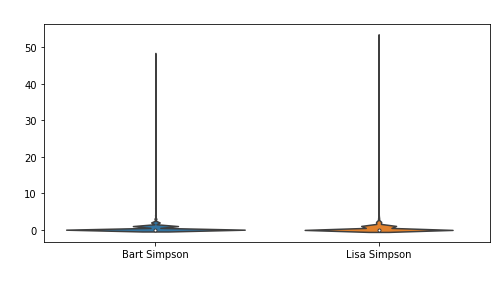

In [73]:
what = "num_words_upper"
train_df[what].loc[train_df[what]>80] = 80 #truncation for better visuals
plt.figure(figsize=(8,4))
sns.violinplot(x='author', y=what, data=train_df)
plt.xlabel('Author Name', fontsize=12, color="white")
plt.ylabel(what, fontsize=12, color="white")
plt.title(what, fontsize=15, color="white")
plt.show()

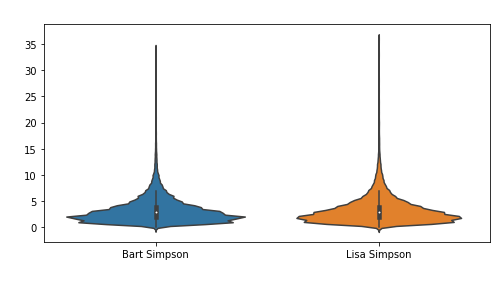

In [74]:
what = "num_punctuations"
train_df[what].loc[train_df[what]>80] = 80 #truncation for better visuals
plt.figure(figsize=(8,4))
sns.violinplot(x='author', y=what, data=train_df)
plt.xlabel('Author Name', fontsize=12, color="white")
plt.ylabel(what, fontsize=12, color="white")
plt.title(what, fontsize=15, color="white")
plt.show()

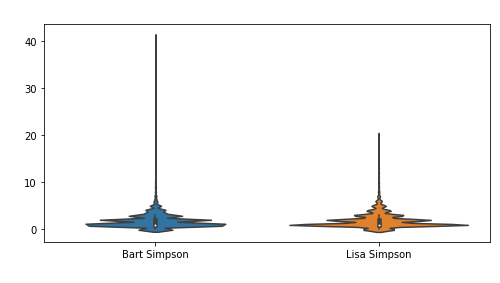

In [75]:
what = "num_words_title"
train_df[what].loc[train_df[what]>80] = 80 #truncation for better visuals
plt.figure(figsize=(8,4))
sns.violinplot(x='author', y=what, data=train_df)
plt.xlabel('Author Name', fontsize=12, color="white")
plt.ylabel(what, fontsize=12, color="white")
plt.title(what, fontsize=15, color="white")
plt.show()